In [1]:
from IPython.display import display,HTML
def dhtml(st):
    display(HTML("""<style>
    @import url('https://fonts.googleapis.com/css?family=Roboto|Ewert&effect=3d');      
    </style><p class='font-effect-3d' onclick='setStyle(this,"#00ff66")'
    style='font-family:Roboto; font-size:25px; color:#ff355e;'>
    %s</p>"""%st+"""<script>
    function setStyle(element,c) {
     var docs=document.getElementsByClassName('font-effect-3d');
     for (var i=0; i<docs.length; i++) {
         docs[i].style='font-family:Ewert; font-size:22px;'; 
         docs[i].style.color=c;}; };
    </script>"""))
dhtml('Code Modules & Helpful Functions')

In [0]:
import numpy as np,pylab as pl,pandas as pd
import sys,h5py,urllib,zipfile
import tensorflow as tf
import tensorflow_hub as th

In [0]:
def premodel(pixels,dense,mh,labels):
    model=tf.keras.Sequential([
        tf.keras.layers.Input((pixels,pixels,3),
                              name='input'),
        th.KerasLayer(mh,trainable=True),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(dense,activation='relu'),
        tf.keras.layers.Dropout(rate=.5),
        tf.keras.layers.Dense(labels,activation='softmax')])
    model.compile(optimizer='adam',metrics=['accuracy'],
                  loss='sparse_categorical_crossentropy')
    display(model.summary())
    return model
fw='weights.best.hdf5'
def cb(fw):
    early_stopping=tf.keras.callbacks\
    .EarlyStopping(monitor='val_loss',patience=20,verbose=2)
    checkpointer=tf.keras.callbacks\
    .ModelCheckpoint(filepath=fw,save_best_only=True,verbose=2)
    lr_reduction=tf.keras.callbacks\
    .ReduceLROnPlateau(monitor='val_loss',verbose=2,
                       patience=5,factor=.8)
    return [checkpointer,early_stopping,lr_reduction]
def display_resize(x_train,x_valid,x_test,
                   y_valid,pixels):
    x_train=tf.image.resize(x_train,[pixels,pixels])
    x_valid=tf.image.resize(x_valid,[pixels,pixels])
    x_test=tf.image.resize(x_test,[pixels,pixels])
    img=x_valid[1]
    lbl='One example of resized images \nlabel: '+\
     str(y_valid[1][0])+'\nshape: '+str(img.shape)
    pl.imshow(img); pl.title(lbl)
    return [x_train,x_valid,x_test]

In [4]:
dhtml('Data Loading & Preprocessing')

In [5]:
fpath='https://olgabelitskaya.github.io/'
zf='LetterColorImages_123.h5.zip'
input_file=urllib.request.urlopen(fpath+zf)
output_file=open(zf,'wb'); 
output_file.write(input_file.read())
output_file.close(); input_file.close()
zipf=zipfile.ZipFile(zf,'r')
zipf.extractall(''); zipf.close()
f=h5py.File(zf[:-4],'r')
keys=list(f.keys()); print(keys)
x=np.array(f[keys[1]],dtype='float32')/255
y=np.array(f[keys[2]],dtype='int32')\
.reshape(-1,1)-1
N=len(y); n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(23).shuffle(shuffle_ids)
x,y=x[shuffle_ids],y[shuffle_ids]
x_test,x_valid,x_train=x[:n],x[n:2*n],x[2*n:]
y_test,y_valid,y_train=y[:n],y[n:2*n],y[2*n:]
x_valid.shape,y_valid.shape

['backgrounds', 'images', 'labels']


((1419, 32, 32, 3), (1419, 1))

In [6]:
dhtml('Pre-Trained Saved Models')

In [7]:
[handle_base,pixels]=["mobilenet_v2_050_96",96]
dhtml('#1 '+handle_base)
mhandle="https://tfhub.dev/google/imagenet/{}/feature_vector/4"\
.format(handle_base)

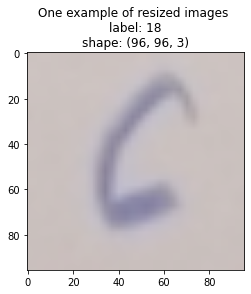

In [8]:
[x_train1,x_valid1,x_test1]=\
display_resize(x_train,x_valid,x_test,
               y_valid,pixels)

In [9]:
model=premodel(pixels,512,mhandle,33)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              706224    
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 33)                16929     
Total params: 1,379,025
Trainable params: 1,360,481
Non-trainable params: 18,544
_________________________________________________________________


None

In [10]:
history=model.fit(x=x_train1,y=y_train,batch_size=64,
                  epochs=50,callbacks=cb(fw),
                  validation_data=(x_valid1,y_valid))

Epoch 1/50
178/178 [==============================] - ETA: 0s - loss: 1.3934 - accuracy: 0.6185
Epoch 00001: val_loss improved from inf to 2.16060, saving model to weights.best.hdf5
178/178 [==============================] - 19s 107ms/step - loss: 1.3934 - accuracy: 0.6185 - val_loss: 2.1606 - val_accuracy: 0.5060 - lr: 0.0010
Epoch 2/50
177/178 [============================>.] - ETA: 0s - loss: 0.4235 - accuracy: 0.8852
Epoch 00002: val_loss improved from 2.16060 to 0.84308, saving model to weights.best.hdf5
178/178 [==============================] - 17s 95ms/step - loss: 0.4246 - accuracy: 0.8850 - val_loss: 0.8431 - val_accuracy: 0.8062 - lr: 0.0010
Epoch 3/50
177/178 [============================>.] - ETA: 0s - loss: 0.3136 - accuracy: 0.9211
Epoch 00003: val_loss improved from 0.84308 to 0.51834, saving model to weights.best.hdf5
178/178 [==============================] - 17s 96ms/step - loss: 0.3138 - accuracy: 0.9208 - val_loss: 0.5183 - val_accuracy: 0.8788 - lr: 0.0010
Epoch 4

In [11]:
model.load_weights(fw)
model.evaluate(x_test1,y_test)

45/45 [==============================] - 1s 15ms/step - loss: 0.1887 - accuracy: 0.9739


[0.18869732320308685, 0.9739252924919128]

In [12]:
[handle_base,pixels]=["mobilenet_v2_075_96",96]
dhtml('#2 '+handle_base)
mhandle="https://tfhub.dev/google/imagenet/{}/feature_vector/4"\
.format(handle_base)

In [13]:
model=premodel(pixels,1024,mhandle,33)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              1382064   
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 33)                33825     
Total params: 2,727,633
Trainable params: 2,700,993
Non-trainable params: 26,640
_________________________________________________________________


None

In [14]:
history=model.fit(x=x_train1,y=y_train,batch_size=64,
                  epochs=50,callbacks=cb(fw),
                  validation_data=(x_valid1,y_valid))

Epoch 1/50
178/178 [==============================] - ETA: 0s - loss: 1.3171 - accuracy: 0.6398
Epoch 00001: val_loss improved from inf to 1.61694, saving model to weights.best.hdf5
178/178 [==============================] - 24s 137ms/step - loss: 1.3171 - accuracy: 0.6398 - val_loss: 1.6169 - val_accuracy: 0.6702 - lr: 0.0010
Epoch 2/50
178/178 [==============================] - ETA: 0s - loss: 0.4228 - accuracy: 0.8966
Epoch 00002: val_loss improved from 1.61694 to 0.68293, saving model to weights.best.hdf5
178/178 [==============================] - 23s 129ms/step - loss: 0.4228 - accuracy: 0.8966 - val_loss: 0.6829 - val_accuracy: 0.8471 - lr: 0.0010
Epoch 3/50
178/178 [==============================] - ETA: 0s - loss: 0.3207 - accuracy: 0.9255
Epoch 00003: val_loss improved from 0.68293 to 0.59582, saving model to weights.best.hdf5
178/178 [==============================] - 23s 129ms/step - loss: 0.3207 - accuracy: 0.9255 - val_loss: 0.5958 - val_accuracy: 0.8710 - lr: 0.0010
Epoch

In [16]:
model.load_weights(fw)
model.evaluate(x_test1,y_test)

45/45 [==============================] - 1s 19ms/step - loss: 0.1723 - accuracy: 0.9817


[0.17225578427314758, 0.981677234172821]

In [15]:
[handle_base,pixels]=["mobilenet_v1_100_128",128]
dhtml('#3 '+handle_base)
mhandle="https://tfhub.dev/google/imagenet/{}/feature_vector/4"\
.format(handle_base)

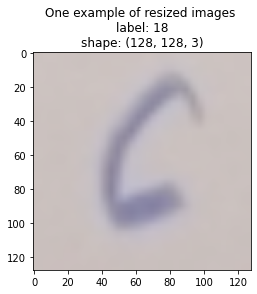

In [17]:
[x_train1,x_valid1,x_test1]=\
display_resize(x_train,x_valid,x_test,
               y_valid,pixels)

In [18]:
model=premodel(pixels,1024,mhandle,33)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1024)              3228864   
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 33)                33825     
Total params: 4,312,289
Trainable params: 4,290,401
Non-trainable params: 21,888
_________________________________________________________________


None

In [19]:
history=model.fit(x=x_train1,y=y_train,batch_size=64,
                  epochs=50,callbacks=cb(fw),
                  validation_data=(x_valid1,y_valid))

Epoch 1/50
178/178 [==============================] - ETA: 0s - loss: 1.2749 - accuracy: 0.6831
Epoch 00001: val_loss improved from inf to 1.80100, saving model to weights.best.hdf5
178/178 [==============================] - 36s 205ms/step - loss: 1.2749 - accuracy: 0.6831 - val_loss: 1.8010 - val_accuracy: 0.6025 - lr: 0.0010
Epoch 2/50
178/178 [==============================] - ETA: 0s - loss: 0.3682 - accuracy: 0.9297
Epoch 00002: val_loss improved from 1.80100 to 0.55125, saving model to weights.best.hdf5
178/178 [==============================] - 36s 200ms/step - loss: 0.3682 - accuracy: 0.9297 - val_loss: 0.5512 - val_accuracy: 0.8767 - lr: 0.0010
Epoch 3/50
178/178 [==============================] - ETA: 0s - loss: 0.3185 - accuracy: 0.9478
Epoch 00003: val_loss improved from 0.55125 to 0.39104, saving model to weights.best.hdf5
178/178 [==============================] - 36s 202ms/step - loss: 0.3185 - accuracy: 0.9478 - val_loss: 0.3910 - val_accuracy: 0.9302 - lr: 0.0010
Epoch

In [20]:
model.load_weights(fw)
model.evaluate(x_test1,y_test)

45/45 [==============================] - 1s 26ms/step - loss: 0.2231 - accuracy: 0.9845


[0.22312051057815552, 0.9844961166381836]

In [21]:
[handle_base,pixels]=["mobilenet_v2_050_128",128]
dhtml('#4 '+handle_base)
mhandle="https://tfhub.dev/google/imagenet/{}/feature_vector/4"\
.format(handle_base)

In [22]:
model=premodel(pixels,1024,mhandle,33)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1280)              706224    
_________________________________________________________________
flatten_3 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 33)                33825     
Total params: 2,051,793
Trainable params: 2,033,249
Non-trainable params: 18,544
_________________________________________________________________


None

In [23]:
history=model.fit(x=x_train1,y=y_train,batch_size=64,
                  epochs=50,callbacks=cb(fw),
                  validation_data=(x_valid1,y_valid))

Epoch 1/50
178/178 [==============================] - ETA: 0s - loss: 1.1869 - accuracy: 0.6712
Epoch 00001: val_loss improved from inf to 1.46902, saving model to weights.best.hdf5
178/178 [==============================] - 28s 159ms/step - loss: 1.1869 - accuracy: 0.6712 - val_loss: 1.4690 - val_accuracy: 0.6857 - lr: 0.0010
Epoch 2/50
178/178 [==============================] - ETA: 0s - loss: 0.3687 - accuracy: 0.8995
Epoch 00002: val_loss improved from 1.46902 to 0.57116, saving model to weights.best.hdf5
178/178 [==============================] - 26s 145ms/step - loss: 0.3687 - accuracy: 0.8995 - val_loss: 0.5712 - val_accuracy: 0.8584 - lr: 0.0010
Epoch 3/50
178/178 [==============================] - ETA: 0s - loss: 0.2582 - accuracy: 0.9323
Epoch 00003: val_loss improved from 0.57116 to 0.56315, saving model to weights.best.hdf5
178/178 [==============================] - 26s 144ms/step - loss: 0.2582 - accuracy: 0.9323 - val_loss: 0.5632 - val_accuracy: 0.8640 - lr: 0.0010
Epoch

In [24]:
model.load_weights(fw)
model.evaluate(x_test1,y_test)

45/45 [==============================] - 1s 19ms/step - loss: 0.1577 - accuracy: 0.9796


[0.15774111449718475, 0.9795630574226379]